# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from torchmetrics import MeanAbsoluteError, F1Score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import time

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images

# data_aug = transforms.Compose([
#     transforms.ToImage(),
#     transforms.RandomPerspective(distortion_scale=0.15, p=0.5),  # Simulate board angles
#     transforms.RandomAffine(
#         degrees=20,  # Rotation
#         translate=(0.1, 0.1),  # Shift
#         scale=(0.9, 1.1),  # Zoom
#         shear=10  # Skew
#     ),
#     transforms.RandomHorizontalFlip(p=0.5),  # Mirror board
#     transforms.ColorJitter(
#         brightness=0.3,  # More aggressive than before
#         contrast=0.3,
#         saturation=0.2,
#         hue=0.02
#     ),
#     transforms.RandomGrayscale(p=0.1),  # Occasional grayscale 
#     transforms.Resize((256, 256)),
#     transforms.RandomCrop(224),
#     transforms.ToDtype(torch.float32, scale=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]

        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1).long()
        
        assert torch.all(self.num_pieces <= 32), "Invalid piece count >32"

        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        return image, num_pieces

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 32
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([32, 224, 224, 3])
torch.Size([32])
tensor(1)


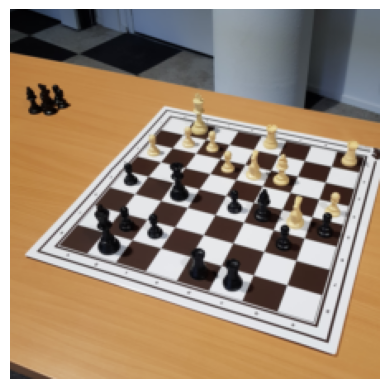

In [5]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# **Now trying new approach with a different model**



## Defining the model

We will use a pre-trained ResNet50 network.

In [6]:
from torchvision.models import efficientnet_b0, efficientnet_b4

# First we started with EfficientNet-B0 and optimized it and then we moved to EfficientNet-B4

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# # Load pretrained EfficientNet-B0
# model = efficientnet_b0(pretrained=True)

model = efficientnet_b4(pretrained=True)

num_classes = 33 # 0 to 32 pieces

# # MODELO "CLASSIFICAÇÃO" LENTO
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 33)  # 33 classes → Desnecessariamente complexo

# SOLUÇÃO IDEAL (Contagem via classificação eficiente):
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.SiLU(), 
    nn.Linear(256, 33)
)
# Move model to device
model.to(device)


Using cuda device


c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Train the model

Define function to perform one iteration

In [7]:
def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    # Set model mode and move data to device
    model.train() if is_train else model.eval()
    images = images.to(device, non_blocking=True)  # non_blocking for faster data transfer
    labels = labels.to(device).long()
    
    # Forward pass
    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization only in training
        if is_train:
            optimizer.zero_grad(set_to_none=True)  # More memory efficient
            loss.backward()
            optimizer.step()
    
    # Calculate metrics
    _, preds = torch.max(outputs, 1)
    preds_np = preds.cpu().numpy()
    labels_np = labels.cpu().numpy()
    accuracy = accuracy_score(labels_np, preds_np)
    mae = torch.abs(preds.float() - labels.float()).mean().item()
    f1 = F1Score(task='multiclass', num_classes=33)(preds.cpu(), labels.cpu()).item()
    
    return loss.item(), outputs, float(accuracy), float(mae), float(f1)

Define function to train a model

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    # Initialize history dictionaries
    train_history = {'loss': [], 'accuracy': [], 'mae': [], 'f1': []}
    val_history = {'loss': [], 'accuracy': [], 'mae': [], 'f1': []}

    total_train_time = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train()
        train_stats = {
            'loss': 0.0,
            'accuracy': 0.0,
            'mae': 0.0,
            'f1': 0.0,
            'total': 0
        }

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, (images, labels) in enumerate(train_bar):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device)

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate metrics
                _, preds = torch.max(outputs, 1)
                preds_np = preds.detach().cpu().numpy()
                labels_np = labels.detach().cpu().numpy()

                batch_accuracy = accuracy_score(labels_np, preds_np)
                batch_mae = MeanAbsoluteError()(torch.tensor(preds_np), torch.tensor(labels_np)).item()
                batch_f1 = F1Score(task='multiclass', num_classes=33)(torch.tensor(preds_np), torch.tensor(labels_np)).item()

            # Backward pass
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # Update running stats
            batch_size = images.size(0)
            train_stats['loss'] += loss.item() * batch_size
            train_stats['accuracy'] += batch_accuracy * batch_size
            train_stats['mae'] += batch_mae * batch_size
            train_stats['f1'] += batch_f1 * batch_size
            train_stats['total'] += batch_size

            # Update progress bar
            avg_loss = train_stats['loss'] / train_stats['total']
            avg_acc = train_stats['accuracy'] / train_stats['total']
            avg_mae = train_stats['mae'] / train_stats['total']
            avg_f1 = train_stats['f1'] / train_stats['total']
            
            train_bar.set_postfix(
                loss=f"{avg_loss:.4f}",
                acc=f"{avg_acc:.2%}",
                mae=f"{avg_mae:.2f}",
                f1=f"{avg_f1:.4f}"
            )

        # Store training metrics
        train_history['loss'].append(train_stats['loss'] / train_stats['total'])
        train_history['accuracy'].append(train_stats['accuracy'] / train_stats['total'])
        train_history['mae'].append(train_stats['mae'] / train_stats['total'])
        train_history['f1'].append(train_stats['f1'] / train_stats['total'])

        print(
            f"✔️ Train Loss: {train_history['loss'][-1]:.4f} | "
            f"Acc: {train_history['accuracy'][-1]:.2%} | "
            f"MAE: {train_history['mae'][-1]:.2f} peças | "
            f"F1: {train_history['f1'][-1]:.4f}"
        )

        # --- Validation Phase ---
        if val_loader:
            model.eval()
            val_stats = {
                'loss': 0.0,
                'accuracy': 0.0,
                'mae': 0.0,
                'f1': 0.0,
                'total': 0
            }

            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            with torch.no_grad():
                for images, labels in val_bar:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    # Calculate metrics
                    _, preds = torch.max(outputs, 1)
                    preds_np = preds.cpu().numpy()
                    labels_np = labels.cpu().numpy()

                    batch_accuracy = accuracy_score(labels_np, preds_np)
                    batch_mae = MeanAbsoluteError()(torch.tensor(preds_np), torch.tensor(labels_np)).item()
                    batch_f1 = F1Score(task='multiclass', num_classes=33)(torch.tensor(preds_np), torch.tensor(labels_np)).item()

                    # Update running stats
                    batch_size = images.size(0)
                    val_stats['loss'] += loss.item() * batch_size
                    val_stats['accuracy'] += batch_accuracy * batch_size
                    val_stats['mae'] += batch_mae * batch_size
                    val_stats['f1'] += batch_f1 * batch_size
                    val_stats['total'] += batch_size

                    # Update progress bar
                    avg_loss = val_stats['loss'] / val_stats['total']
                    avg_acc = val_stats['accuracy'] / val_stats['total']
                    avg_mae = val_stats['mae'] / val_stats['total']
                    avg_f1 = val_stats['f1'] / val_stats['total']
                    
                    val_bar.set_postfix(
                        loss=f"{avg_loss:.4f}",
                        acc=f"{avg_acc:.2%}",
                        mae=f"{avg_mae:.2f}",
                        f1=f"{avg_f1:.4f}"
                    )

            # Store validation metrics
            val_history['loss'].append(val_stats['loss'] / val_stats['total'])
            val_history['accuracy'].append(val_stats['accuracy'] / val_stats['total'])
            val_history['mae'].append(val_stats['mae'] / val_stats['total'])
            val_history['f1'].append(val_stats['f1'] / val_stats['total'])

            print(
                f"🔍 Val Loss: {val_history['loss'][-1]:.4f} | "
                f"Acc: {val_history['accuracy'][-1]:.2%} | "
                f"MAE: {val_history['mae'][-1]:.2f} peças | "
                f"F1: {val_history['f1'][-1]:.4f}"
            )

            # Save best model
            if val_history['loss'][-1] < best_val_loss:
                best_val_loss = val_history['loss'][-1]
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Saved best model (Loss: {best_val_loss:.4f})")

        epoch_time = time.time() - epoch_start_time
        total_train_time += epoch_time
        print(f"⏱️  Epoch time: {epoch_time:.2f}s")

    print(f"\nTotal training time: {total_train_time:.2f} seconds")
    return train_history, val_history, total_train_time

Define loss, optimizer and train the model

In [9]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(train_history['accuracy'], label='Train Accuracy')
    plt.plot(val_history['accuracy'], label='Val Accuracy')
    plt.plot(train_history['f1'], '--', label='Train F1')
    plt.plot(val_history['f1'], '--', label='Val F1')
    plt.title('Accuracy & F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(train_history['mae'], label='Train MAE')
    plt.plot(val_history['mae'], label='Val MAE')
    plt.title('MAE (in pieces)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## **Try another approach for freezing/unfreezing layers**


In [10]:
loss_fn = nn.CrossEntropyLoss()

# Training configuration
unfreeze_steps = [0, 2, 4, 6, 8]
num_epochs_per_step = 10

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Function to unfreeze blocks of the model
def unfreeze_blocks(model, n):
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    if n > 0:
        for block in model.features[-n:]:
            for param in block.parameters():
                param.requires_grad = True

# History dictionaries to store training and validation metrics
train_history_all = {'loss': [], 'accuracy': [], 'mae': [], 'f1': []} 
val_history_all = {'loss': [], 'accuracy': [], 'mae': [], 'f1': []} 
total_train_time = 0.0

for step_idx, n_blocks in enumerate(unfreeze_steps):
    print(f"\n=== Step {step_idx+1}/{len(unfreeze_steps)}: Unfreezing last {n_blocks} blocks ===")
    
    unfreeze_blocks(model, n_blocks)
    
    # Optimizer and scheduler setup
    params_to_optimize = [{'params': model.classifier.parameters(), 'lr': 1e-3}]
    if n_blocks > 0:
        base_params = []
        for block in model.features[-n_blocks:]:
            base_params += list(block.parameters())
        params_to_optimize.append({'params': base_params, 'lr': 1e-4})
    
    optimizer = optim.Adam(params_to_optimize)
    
    # Train the model for the current step
    train_hist, val_hist, epoch_time = train_model(
        model, 
        train_dataloader, 
        valid_dataloader, 
        optimizer, 
        loss_fn, 
        device, 
        num_epochs=num_epochs_per_step
    )

    total_train_time += epoch_time

    scheduler.step(val_hist['loss'][-1]) 
    
    train_history_all['loss'].extend(train_hist['loss'])
    train_history_all['accuracy'].extend(train_hist['accuracy'])
    train_history_all['mae'].extend(train_hist['mae'])
    train_history_all['f1'].extend(train_hist['f1'])
    val_history_all['loss'].extend(val_hist['loss'])
    val_history_all['accuracy'].extend(val_hist['accuracy'])
    val_history_all['mae'].extend(val_hist['mae'])
    val_history_all['f1'].extend(val_hist['f1'])  

print("\nTraining completed! Total training time: {:.2f} seconds.".format(total_train_time))


=== Step 1/5: Unfreezing last 0 blocks ===

Epoch 1/10


✔️ Train Loss: 3.3050 | Acc: 11.29% | MAE: 8.65 peças | F1: 0.1129


🔍 Val Loss: 3.4314 | Acc: 11.21% | MAE: 12.21 peças | F1: 0.1121
💾 Saved best model (Loss: 3.4314)
⏱️  Epoch time: 186.57s

Epoch 2/10


✔️ Train Loss: 3.0089 | Acc: 15.55% | MAE: 8.06 peças | F1: 0.1555


🔍 Val Loss: 3.4037 | Acc: 15.45% | MAE: 5.27 peças | F1: 0.1545
💾 Saved best model (Loss: 3.4037)
⏱️  Epoch time: 179.54s

Epoch 3/10


✔️ Train Loss: 2.8390 | Acc: 20.31% | MAE: 5.55 peças | F1: 0.2031


🔍 Val Loss: 3.3086 | Acc: 15.45% | MAE: 5.35 peças | F1: 0.1545
💾 Saved best model (Loss: 3.3086)
⏱️  Epoch time: 179.13s

Epoch 4/10


✔️ Train Loss: 2.6781 | Acc: 23.30% | MAE: 4.67 peças | F1: 0.2330


🔍 Val Loss: 3.2410 | Acc: 17.58% | MAE: 4.18 peças | F1: 0.1758
💾 Saved best model (Loss: 3.2410)
⏱️  Epoch time: 178.08s

Epoch 5/10


✔️ Train Loss: 2.5461 | Acc: 25.57% | MAE: 4.29 peças | F1: 0.2557


🔍 Val Loss: 3.2616 | Acc: 15.76% | MAE: 4.12 peças | F1: 0.1576
⏱️  Epoch time: 176.16s

Epoch 6/10


✔️ Train Loss: 2.4648 | Acc: 25.71% | MAE: 4.13 peças | F1: 0.2571


🔍 Val Loss: 3.2776 | Acc: 17.58% | MAE: 3.52 peças | F1: 0.1758
⏱️  Epoch time: 174.39s

Epoch 7/10


✔️ Train Loss: 2.3896 | Acc: 28.48% | MAE: 3.82 peças | F1: 0.2848


🔍 Val Loss: 3.2338 | Acc: 17.88% | MAE: 3.82 peças | F1: 0.1788
💾 Saved best model (Loss: 3.2338)
⏱️  Epoch time: 175.23s

Epoch 8/10


✔️ Train Loss: 2.3744 | Acc: 31.32% | MAE: 3.65 peças | F1: 0.3132


🔍 Val Loss: 3.2959 | Acc: 17.88% | MAE: 3.58 peças | F1: 0.1788
⏱️  Epoch time: 175.53s

Epoch 9/10


✔️ Train Loss: 2.3175 | Acc: 30.47% | MAE: 3.69 peças | F1: 0.3047


🔍 Val Loss: 3.3223 | Acc: 17.58% | MAE: 3.78 peças | F1: 0.1758
⏱️  Epoch time: 175.48s

Epoch 10/10


✔️ Train Loss: 2.2935 | Acc: 31.53% | MAE: 3.76 peças | F1: 0.3153


🔍 Val Loss: 3.3425 | Acc: 17.88% | MAE: 3.50 peças | F1: 0.1788
⏱️  Epoch time: 175.98s

Total training time: 1776.09 seconds

=== Step 2/5: Unfreezing last 2 blocks ===

Epoch 1/10


✔️ Train Loss: 2.2863 | Acc: 30.26% | MAE: 3.47 peças | F1: 0.3026


🔍 Val Loss: 3.5010 | Acc: 17.58% | MAE: 3.46 peças | F1: 0.1758
💾 Saved best model (Loss: 3.5010)
⏱️  Epoch time: 177.13s

Epoch 2/10


✔️ Train Loss: 2.1698 | Acc: 32.32% | MAE: 3.35 peças | F1: 0.3232


🔍 Val Loss: 3.5833 | Acc: 16.97% | MAE: 3.31 peças | F1: 0.1697
⏱️  Epoch time: 175.55s

Epoch 3/10


✔️ Train Loss: 2.1142 | Acc: 34.87% | MAE: 3.19 peças | F1: 0.3487


🔍 Val Loss: 3.7251 | Acc: 19.39% | MAE: 3.28 peças | F1: 0.1939
⏱️  Epoch time: 176.33s

Epoch 4/10


✔️ Train Loss: 2.0693 | Acc: 35.44% | MAE: 2.99 peças | F1: 0.3544


🔍 Val Loss: 3.7466 | Acc: 16.06% | MAE: 3.31 peças | F1: 0.1606
⏱️  Epoch time: 176.44s

Epoch 5/10


✔️ Train Loss: 2.0855 | Acc: 35.94% | MAE: 2.96 peças | F1: 0.3594


🔍 Val Loss: 3.7176 | Acc: 19.09% | MAE: 3.00 peças | F1: 0.1909
⏱️  Epoch time: 177.23s

Epoch 6/10


✔️ Train Loss: 2.0139 | Acc: 36.65% | MAE: 2.69 peças | F1: 0.3665


🔍 Val Loss: 3.7891 | Acc: 18.79% | MAE: 3.02 peças | F1: 0.1879
⏱️  Epoch time: 176.61s

Epoch 7/10


✔️ Train Loss: 1.9579 | Acc: 38.28% | MAE: 2.63 peças | F1: 0.3828


🔍 Val Loss: 3.9277 | Acc: 17.27% | MAE: 3.02 peças | F1: 0.1727
⏱️  Epoch time: 176.32s

Epoch 8/10


✔️ Train Loss: 1.9334 | Acc: 38.42% | MAE: 2.56 peças | F1: 0.3842


🔍 Val Loss: 3.9025 | Acc: 19.70% | MAE: 2.93 peças | F1: 0.1970
⏱️  Epoch time: 175.74s

Epoch 9/10


✔️ Train Loss: 1.9040 | Acc: 38.78% | MAE: 2.52 peças | F1: 0.3878


🔍 Val Loss: 3.9577 | Acc: 20.30% | MAE: 2.95 peças | F1: 0.2030
⏱️  Epoch time: 177.70s

Epoch 10/10


✔️ Train Loss: 1.8638 | Acc: 40.84% | MAE: 2.46 peças | F1: 0.4084


🔍 Val Loss: 3.9640 | Acc: 19.09% | MAE: 2.88 peças | F1: 0.1909
⏱️  Epoch time: 177.36s

Total training time: 1766.40 seconds

=== Step 3/5: Unfreezing last 4 blocks ===

Epoch 1/10


✔️ Train Loss: 1.8927 | Acc: 39.99% | MAE: 2.45 peças | F1: 0.3999


🔍 Val Loss: 4.0583 | Acc: 19.09% | MAE: 2.84 peças | F1: 0.1909
💾 Saved best model (Loss: 4.0583)
⏱️  Epoch time: 179.91s

Epoch 2/10


✔️ Train Loss: 1.7787 | Acc: 43.82% | MAE: 2.13 peças | F1: 0.4382


🔍 Val Loss: 4.0669 | Acc: 17.88% | MAE: 2.77 peças | F1: 0.1788
⏱️  Epoch time: 180.81s

Epoch 3/10


✔️ Train Loss: 1.6876 | Acc: 44.53% | MAE: 2.03 peças | F1: 0.4453


🔍 Val Loss: 4.3923 | Acc: 18.18% | MAE: 2.65 peças | F1: 0.1818
⏱️  Epoch time: 178.96s

Epoch 4/10


✔️ Train Loss: 1.6382 | Acc: 46.38% | MAE: 1.81 peças | F1: 0.4638


🔍 Val Loss: 4.4315 | Acc: 16.06% | MAE: 2.65 peças | F1: 0.1606
⏱️  Epoch time: 179.93s

Epoch 5/10


✔️ Train Loss: 1.5687 | Acc: 47.73% | MAE: 1.73 peças | F1: 0.4773


🔍 Val Loss: 4.4800 | Acc: 17.88% | MAE: 2.48 peças | F1: 0.1788
⏱️  Epoch time: 179.50s

Epoch 6/10


✔️ Train Loss: 1.5241 | Acc: 48.86% | MAE: 1.63 peças | F1: 0.4886


🔍 Val Loss: 4.5061 | Acc: 17.58% | MAE: 2.53 peças | F1: 0.1758
⏱️  Epoch time: 179.67s

Epoch 7/10


✔️ Train Loss: 1.4453 | Acc: 51.49% | MAE: 1.49 peças | F1: 0.5149


🔍 Val Loss: 4.5620 | Acc: 17.58% | MAE: 2.53 peças | F1: 0.1758
⏱️  Epoch time: 180.18s

Epoch 8/10


✔️ Train Loss: 1.4001 | Acc: 54.05% | MAE: 1.43 peças | F1: 0.5405


🔍 Val Loss: 4.6783 | Acc: 16.97% | MAE: 2.49 peças | F1: 0.1697
⏱️  Epoch time: 179.44s

Epoch 9/10


✔️ Train Loss: 1.3666 | Acc: 54.19% | MAE: 1.36 peças | F1: 0.5419


🔍 Val Loss: 4.8763 | Acc: 16.06% | MAE: 2.45 peças | F1: 0.1606
⏱️  Epoch time: 179.74s

Epoch 10/10


✔️ Train Loss: 1.3315 | Acc: 55.89% | MAE: 1.36 peças | F1: 0.5589


🔍 Val Loss: 4.8870 | Acc: 17.58% | MAE: 2.49 peças | F1: 0.1758
⏱️  Epoch time: 179.71s

Total training time: 1797.86 seconds

=== Step 4/5: Unfreezing last 6 blocks ===

Epoch 1/10


✔️ Train Loss: 1.2880 | Acc: 56.82% | MAE: 1.19 peças | F1: 0.5682


🔍 Val Loss: 5.0861 | Acc: 16.67% | MAE: 2.45 peças | F1: 0.1667
💾 Saved best model (Loss: 5.0861)
⏱️  Epoch time: 231.62s

Epoch 2/10


✔️ Train Loss: 1.2915 | Acc: 56.61% | MAE: 1.32 peças | F1: 0.5661


🔍 Val Loss: 4.9193 | Acc: 17.27% | MAE: 2.30 peças | F1: 0.1727
💾 Saved best model (Loss: 4.9193)
⏱️  Epoch time: 229.50s

Epoch 3/10


✔️ Train Loss: 1.2186 | Acc: 58.66% | MAE: 1.28 peças | F1: 0.5866


🔍 Val Loss: 4.9067 | Acc: 18.18% | MAE: 2.40 peças | F1: 0.1818
💾 Saved best model (Loss: 4.9067)
⏱️  Epoch time: 228.94s

Epoch 4/10


✔️ Train Loss: 1.2097 | Acc: 60.30% | MAE: 1.11 peças | F1: 0.6030


🔍 Val Loss: 5.0398 | Acc: 17.88% | MAE: 2.19 peças | F1: 0.1788
⏱️  Epoch time: 229.17s

Epoch 5/10


✔️ Train Loss: 1.1904 | Acc: 60.23% | MAE: 1.18 peças | F1: 0.6023


🔍 Val Loss: 4.9041 | Acc: 17.27% | MAE: 2.38 peças | F1: 0.1727
💾 Saved best model (Loss: 4.9041)
⏱️  Epoch time: 228.28s

Epoch 6/10


✔️ Train Loss: 1.1043 | Acc: 63.14% | MAE: 1.01 peças | F1: 0.6314


🔍 Val Loss: 4.9298 | Acc: 21.52% | MAE: 2.22 peças | F1: 0.2152
⏱️  Epoch time: 228.74s

Epoch 7/10


✔️ Train Loss: 1.1083 | Acc: 62.57% | MAE: 1.03 peças | F1: 0.6257


🔍 Val Loss: 5.0330 | Acc: 15.45% | MAE: 2.24 peças | F1: 0.1545
⏱️  Epoch time: 229.73s

Epoch 8/10


✔️ Train Loss: 0.9775 | Acc: 66.62% | MAE: 0.96 peças | F1: 0.6662


🔍 Val Loss: 5.1855 | Acc: 16.97% | MAE: 2.24 peças | F1: 0.1697
⏱️  Epoch time: 228.70s

Epoch 9/10


✔️ Train Loss: 1.0200 | Acc: 65.98% | MAE: 0.96 peças | F1: 0.6598


🔍 Val Loss: 5.1738 | Acc: 16.67% | MAE: 2.09 peças | F1: 0.1667
⏱️  Epoch time: 228.82s

Epoch 10/10


✔️ Train Loss: 0.9944 | Acc: 66.05% | MAE: 0.95 peças | F1: 0.6605


🔍 Val Loss: 5.2357 | Acc: 16.36% | MAE: 2.18 peças | F1: 0.1636
⏱️  Epoch time: 227.80s

Total training time: 2291.30 seconds

=== Step 5/5: Unfreezing last 8 blocks ===

Epoch 1/10


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.15 GiB is allocated by PyTorch, and 191.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

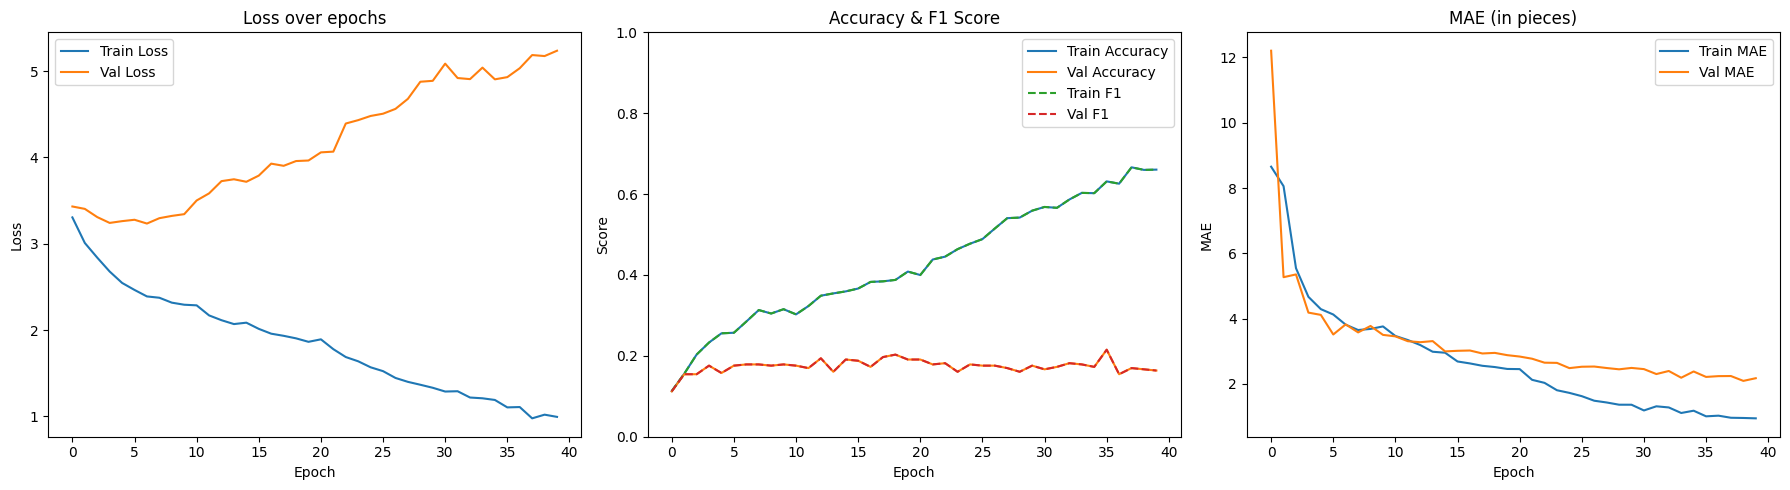

In [11]:
plot_training_history(train_history_all, val_history_all)

## Test the model

Evaluate the model in the test set

In [7]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [8]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_stats = {
        'loss': 0.0,
        'accuracy': 0.0,
        'mae': 0.0,
        'f1': 0.0,
        'total': 0
    }

    all_labels = []
    all_preds = []

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Convert to numpy for metrics calculation
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()

            # Calculate batch metrics
            batch_accuracy = accuracy_score(labels_np, preds_np)
            batch_mae = MeanAbsoluteError()(torch.tensor(preds_np), torch.tensor(labels_np)).item()
            batch_f1 = F1Score(task='multiclass', num_classes=33)(torch.tensor(preds_np), torch.tensor(labels_np)).item()

            # Update running stats
            batch_size = images.size(0)
            running_stats['loss'] += loss.item() * batch_size
            running_stats['accuracy'] += batch_accuracy * batch_size
            running_stats['mae'] += batch_mae * batch_size
            running_stats['f1'] += batch_f1 * batch_size
            running_stats['total'] += batch_size

            # Update progress bar
            test_bar.set_postfix(
                loss=f"{running_stats['loss']/running_stats['total']:.4f}",
                acc=f"{running_stats['accuracy']/running_stats['total']:.2%}",
                mae=f"{running_stats['mae']/running_stats['total']:.2f}",
                f1=f"{running_stats['f1']/running_stats['total']:.4f}"
            )

            # Store for confusion matrix
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Calculate final metrics
    test_loss = running_stats['loss'] / running_stats['total']
    test_accuracy = running_stats['accuracy'] / running_stats['total']
    test_mae = running_stats['mae'] / running_stats['total']
    test_f1 = running_stats['f1'] / running_stats['total']

    # Generate reports
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    
    print("\n" + "="*50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2%}")  # Formato percentual
    print(f"Test MAE: {test_mae:.2f} peças")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("-"*50)
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))
    print("="*50)

    return test_loss, test_accuracy, test_mae, test_f1

In [9]:
# Carrega o modelo e testa
loss_fn = nn.CrossEntropyLoss()
best_model_path = 'best_model.pth' 
load_model(model, best_model_path, device)
test_loss, test_accuracy, test_mae, test_f1 = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it, acc=25.16%, f1=0.2516, loss=3.5031, mae=2.09]


Test Loss: 3.5031
Test Accuracy: 25.16%
Test MAE: 2.09 peças
Test F1-Score: 0.2516
--------------------------------------------------
Confusion Matrix:
[[ 0  0  2  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  3  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  2  0  1  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  3  0  2  0  5  7  8  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  3  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  1  0  0 13  3  1  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  1  7 10  4  1  3  0  2  0  0  0  0  0  0  0  0  0  0